# Classification using k Nearest Neighbours

Previously we have considered regression problems for Machine Learning, where the target value is a continuous variable. The other primary type of supervised learning problem is classification problems. For example, a common Machine Learning problem is that we are given a number of images of animals, and we need to classify them into the various animals such as cats, dogs and horses. Another type of problem is the 'Churn problem', for which the object is to predict whether a customer will continue with a company based on their past activities. This is known as a binary classification problem, since there is only the two outcomes that either the customer will continue or they will not.

One of the simplest classification algorithms is k-Nearest Neighbours (kNN). Consider that our dataset consists of m continuous features and 1 discrete target value, and we have n instances or measurements. Then the features can be plotted in 'feature space'. For two features this corresponds to the plane and for three features to three-dimensional space. Each pair of instances will be separated by a distance d. This is know as the Euclidean distance. If we are trying to predict the label for a particular instance the algorithm then finds the k nearest neighbours and records the target values for these neighbours. Then the most common target value is chosen as the label for that particular instance. This is known as 'hard' voting. An alternative form of hard voting is where the votes are weighted by the distance away from the instance, and therefore closer points have more importance.

In this lesson we will use the [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which is a famous dataset which classifies three species of iris based on the dimensions of the flowers. We will also show how functions can be defined to repeat tasks.

We first import libraries that will be required later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd

## Contents

* Iris Dataset
* kNN Algorithm
* Confusion Matrix and Accuracy
* Normalization

## Iris Dataset 

The Iris Dataset can be loaded using seaborn. If we print the shape there are are 150 instances and for each instance there are 4 features and 1 label. The features correspond to measurements of the flowers, and the target value is the species.

In [2]:
iris = sns.load_dataset('iris') # load the dataset from seaborn
print('Shape of the iris dataset is',iris.shape) # display the shape of the data
iris.head() # display the first few lines

Shape of the iris dataset is (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can view the descriptive statistics of the numerical columns using `df.describe()`.

In [3]:
iris.describe() # show the statistics of the numerical columns

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We can also see the unique values of the species label. In this case there are three types of species or labels. We will be attempting to predict these labels, though it is easier to work with equivalent numerical labels.

In [4]:
iris['species'].unique() # show the unique values of the species column

array(['setosa', 'versicolor', 'virginica'], dtype=object)

We will try to predict the species using only the sepal length and sepal width, therefore it is helpful to plot how the labels vary with these features. As can be seen the setosa species is fairly well separated from the other two species, but the boundary between versicolor and viginica is fairly fuzzy.

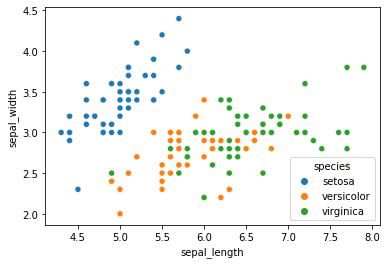

In [5]:
sns.scatterplot(x="sepal_length", y="sepal_width", hue='species', data=iris); 

Finally, we define a vector with the names of the species, which will be used for plotting, and convert the species names to a categorical code. This makes classification simpler and also saves storage space. If we plot a random sample of the instances, it can be seen that each categorical code corresponds to a particular species.

In [6]:
iris['code'] = iris.species.astype('category').cat.codes 
categories = iris.species.unique() # create a vector with the category names,
iris.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,species,code
6,4.6,3.4,1.4,0.3,setosa,0
22,4.6,3.6,1.0,0.2,setosa,0
100,6.3,3.3,6.0,2.5,virginica,2
1,4.9,3.0,1.4,0.2,setosa,0
5,5.4,3.9,1.7,0.4,setosa,0
99,5.7,2.8,4.1,1.3,versicolor,1
41,4.5,2.3,1.3,0.3,setosa,0
24,4.8,3.4,1.9,0.2,setosa,0
81,5.5,2.4,3.7,1.0,versicolor,1
75,6.6,3.0,4.4,1.4,versicolor,1


## kNN Algorithm 

We first define a function which is helpful for plotting the decision boundaries of the kNN model. The first line defines the name of the function and its argument. The following lines enclosed in triple quotation marks correspond to a 'docstring' and will be printed when using the help facility for this function. Note that the function continues as far as the code is indented.

In [7]:
def plt_decision_boundaries(skm,xx,yy):
    """
    Takes a sklearn model (skm) with two features and plots the decision boundaries.
    xx and yy correspond to matrices with the x and y coordinates.
    """
    # ravel is a numpy method which converts a two-dimensional array of size (n,m) to a vector of length nm
    # column_stack is a numpy function which takes two column arrays of length N 
    # and creates a two-dimensional array of size (N,2)
    # now pass the (N,2) array to the model and predict values based on these features, zz will have size (N,1)
    zz = skm.predict(np.column_stack([xx.ravel(), yy.ravel()]))  
    zz = zz.reshape(xx.shape) # reshape zz so it has the size of the original array xx, i.e., (n,m)
    plt.contourf(xx, yy, zz, cmap=plt.cm.Paired) # plot the decision boundaries as filled contours

From the module `sklearn.neighbors` we import the `KNeighborsClassifier()` function. Then we can set a parameter `n_neighbours` which will control how many neighbors to use in the calculations.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = 5

We then set up our table of features `X` and our target values `y`. The features correspond to the first two features of the iris dataframe, and the target values are the categorical code for the species which was created earlier.

In [9]:
# we only take the first two features. 
X = iris.iloc[:, :2]
y = iris['code']

The syntax to use the kNN algorithm is the same as other `sklearn` functions. We first instantiate the model by passing the appropriate parameters. In this case the two parameters are the number of neighbours to use and the weights for predicted the labels. The choice `weights='uniforms'` indicates that each of the neighbours contribute equally to predicting the target value. The alternate is `weights='distance'` in which case the contribution of neighbours decreases with distance. Once the model is setup, then we train the model by fitting the features `X` and labels `y`. Then the model can be used to predict labels.

In [10]:
clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X, y)

KNeighborsClassifier()

To view the output of the model we can plot the decision boundaries in feature space. We setup an x and y table which cover the feature space using the `numpy` routines `meshgrid()` and `linspace()`. Then for each point in these tables the model predicts the label using kNN and then plots the boundaries where each label applies. We can then overlay the scatter plot we viewed earlier for comparision. As can be seen the boundary between setosa and the other two species is fairly clear, but that between versicolor and virginica is quite irregular.

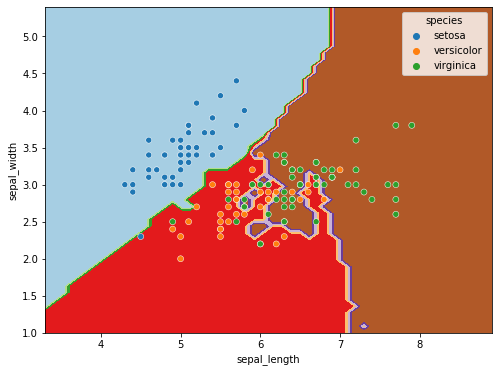

In [11]:
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max),
                     np.linspace(y_min, y_max))
plt.figure(figsize=(8, 6))
plt_decision_boundaries(clf, xx, yy)
sns.scatterplot(x=X["sepal_length"], y=X["sepal_width"], hue=iris['species']);

If the number of neighbours is increased to 15 the boundary between the versicolor and virginica species becomes much more regular, as including more neighbours corresponds to averaging over a larger region.

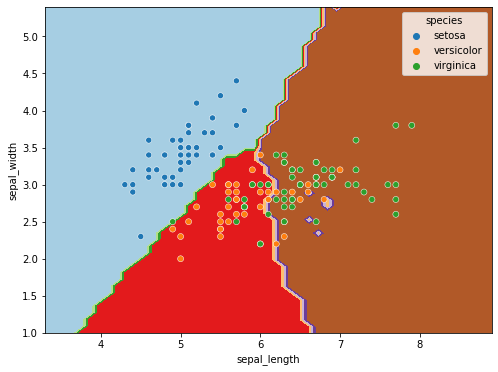

In [12]:
n_neighbours = 15

clf_15 = KNeighborsClassifier(n_neighbours, weights='uniform')
clf_15.fit(X, y)

plt.figure(figsize=(8, 6))
plt_decision_boundaries(clf_15, xx, yy)
sns.scatterplot(x=X["sepal_length"], y=X["sepal_width"], hue=iris['species']);

## Confusion Matrix and Accuracy

We will now look at how we can assess the accuracy of the 5 neighbours kNN model, which we have called `clf`. This will involve introducing the concept of a confusion matrix, and the function below provides a simple method for viewing this. 

The concept of accuracy and confusion matrix which we introduce here apply to classification models in general.

In [13]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Given actual target values and predicted values for a classifier 'method', 
    plots the confusion matrix
    """
    # write the confusion matrix to a dataframe with row and column names as the categories
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats) 
    f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

We introduce the `train_test_split()` function to split our data into training and testing sets, and a function for calculating the confusion matrix and accuracy for classification models.

In [14]:
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.metrics import confusion_matrix # import the confusion matrix function
from sklearn.metrics import accuracy_score # import the score functions 

We first split the data into testing and training sets, as to test the accuracy of the model we want to use data that has not been used to train the model. Then we train the model using the training data, and then predict the output of the model for our testing features `X_test`. These predictions, `y_pred`, can then be compared against the actual values, `y_test`, to assess the accuracy of the model.

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=0)  

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

The first way we can assess the model is to view the confusion matrix. This shows how and where the model makes correct and incorrect predictions. For each label that is predicted by the model this counts the number of times it has correctly predicted the species and the number of times where it should have predicted one of the other species. For example, the model has predicted versicolor seven times. Five of these times it has correctly predicted the species, and twice it has incorrectly predicted the species when it should be virginica. 

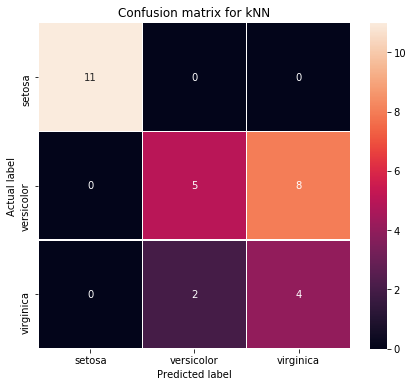

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
plt_confusion_matrix(cnf_matrix, categories, 'kNN')

We can now calculate the accuracy of the model. This is simply the total number of correct predictions, i.e., the sum of the terms on the main diagonal of the confusion matrix, divided by the number of predictions, i.e., the sum of all the terms in the confusion matrix. In this case we have 11+5+4=20 correct predictions, and 11+5+8+2+4=30 total predictions. Therefore the accuracy in this case is 2/3. For a very good model the accuracy will approach 1, whereas for a very poor model the accuracy will approach 0.

In [17]:
print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score

Accuracy: 0.667


## Normalization

For many algorithms, and especially algorithms which are based on the calculation of distances, it is important to normalize the feature variables. For example, consider if one of the features varied from 0.4 to 0.6, whereas another feature varied from 200 to 300. Hence the closest neighbours will be ones for which the second feature is approximately equal to the value of the instance that we are trying to predict, and therefore the second feature is largely redundant for our calculations.

The way to address this is to normalize the variables by the standard deviation of the feature. Recall that the standard deviation is the distance on either side of the mean value in which approximately 70% of the observations lie. In the example above the standard deviation will be approximately 0.1 for the first feature and approximatley 50 for the second feature. If we normalize (divide) by the standard deviation then the first feature will now vary from 4 to 6 and the second feature will also vary from 4 to 6. Hence the distances in each feature direction are now equally weighted, and each feature has an equal contribution to the kNN algorithm.

For the Iris Dataset normalization does not have a huge effect as the the features have similar standard deviations, however we will use this to explain the process. For the exercise example, the normalization does have an important effect.

We first show the standard deviations of the two features we are using. As is apparent they have similar magnitudes.

In [18]:
X.std()

sepal_length    0.828066
sepal_width     0.435866
dtype: float64

We now create a new normalized feature table `Xn`, which is each column of `X` divided by the standard deviation of that column. Then we repeat the calculations from earlier to plot the decision boundaries of the model. Again the decision boundaries between the virginica and versicolor species are fairly irregular.

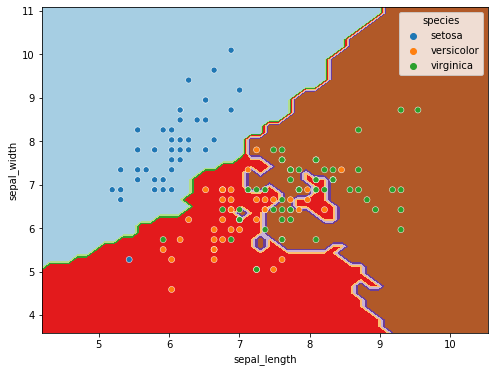

In [19]:
Xn = X/X.std()

n_neighbours = 5

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(Xn, y)
x_min, x_max = Xn.iloc[:, 0].min() - 1, Xn.iloc[:, 0].max() + 1
y_min, y_max = Xn.iloc[:, 1].min() - 1, Xn.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max),
                     np.linspace(y_min, y_max))
plt.figure(figsize=(8, 6))
plt_decision_boundaries(clf, xx, yy)
sns.scatterplot(x=Xn["sepal_length"], y=Xn["sepal_width"], hue=iris['species']);

We then calculate the calculate the confusion matrix and accuracy. In this case the accuracy drops slightly. However, it is best practise to always normalize variables when using the kNN algorithm.

Accuracy: 0.633


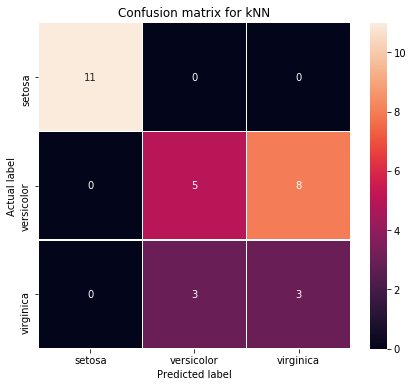

In [21]:
X_train,X_test,y_train,y_test=train_test_split(Xn, y,train_size=0.8,random_state=0)  

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
plt_confusion_matrix(cnf_matrix, categories, 'kNN')

print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score

## Exercises

For these exercises we will use the penguins dataset from seaborn. First, we remove any rows with missing values and then create a numerical code for classification, rather than using the string value of `species`.

In [33]:
penguins = sns.load_dataset('penguins') # load the dataset from seaborn
penguins.dropna(subset=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
                how='any',inplace=True)
penguins['code'] = penguins.species.astype('category').cat.codes 
penguins.head() # display the first few lines

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,code
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0


### Exercise 1 

Create a feature array which consists of the flipper length and bill depth, a target series which consists of the species code and a vector which contains the species names. Plot a scatter plot of the feature array against the target series. (3 marks)

### Exercise 2 

Split the data into testing and training sets, with and 80:20 split. Create a kNN model with 10 nearest neighbours and uniform weights. Fit the training data to this model. Then calculate the predictions of this model for the test features. (3 marks)

### Exercise 3

Calculate and plot the confusion matrix, and calculate accuracy for this model. (2 marks)

### Exercise 4

Repeat the calculations in Exercise 2 and 3, but first normalize the feature array. (2 marks)